Building a model that classifies whether an individual survived the Titanic shipwreck or not. The target variable is the Survived column

In [27]:
#import libraries
import warnings
warnings.filterwarnings('ignore') #to ignore warnings

from sklearn.preprocessing import LabelEncoder      # for encoding categorical variables
from imblearn.over_sampling import SMOTE            # to handle imbalanced data

# load models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier # for ensemble methods
from sklearn.neighbors import KNeighborsClassifier

 # for cross-validation and hyperparameter tuning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV  

#for hyperparameter tuning
from scipy.stats import randint 

#for model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc          # for ROC curve

import pickle       #for saving models

1. Load Data

In [28]:
#import data
df = pd.read_csv(r"C:\Users\Admin\Downloads\LuxDev\notes\ml\supervised\logistic regression(classification)\survived\titanic.csv")

df.head()

<IPython.core.display.Javascript object>

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


2. Preprocessing

In [30]:
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Length: 891, dtype: bool

In [31]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

The dataset has considerable number of missing values in the age(177) and cabin(687) columns that should be filled to avoid affecting the model's accuracy.

Handle missing values

In [32]:
# check for skewness to determine how to handle missing values
skewness = df.select_dtypes(include="number").skew()
skewness

PassengerId    0.000000
Survived       0.478523
Pclass        -0.630548
Age            0.389108
SibSp          3.695352
Parch          2.749117
Fare           4.787317
dtype: float64

from the above skewness insights:
the data is moderately skewed and the best way to impute missing values in such instances is using the median for the age, mode for categorical features (embarked).

We'll drop the cabin feature because its missing values are too many to impute without interfering with the dataset's accuracy

In [33]:
# handle missing values

# age
df["Age"].fillna(df["Age"].median(),inplace=True)

# embarked
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [34]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [35]:
#drop columns that cause model complexity(ID and Name) & errors(Cabin column due to high number of missing values)
df = df.drop(columns=["PassengerId", "Name", "Cabin", 'Ticket'])

# drop ticket column here because it has no significance on the target variable as seen in feature selection,
# and it has a high dimensionality after encoding to perform the feature importance step

3. Exploratory Data Analysis

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

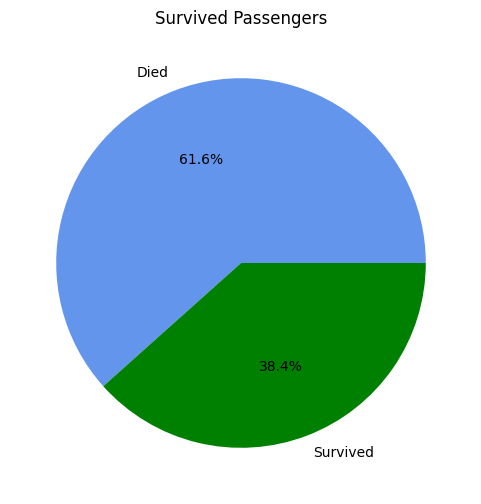

In [36]:
# visualize survived passengers
survived_counts = df['Survived'].value_counts()         #count the occurence of unique values
survived_counts

survived_labels = ["Died", "Survived"]                  #assign label variables for plot

#plot piechart showing gender proportion of survivors
fig, ax =plt.subplots(figsize=(6,6))

# add labels and title
ax.set_title('Survived Passengers')                     #add title
plt.pie(survived_counts, labels=survived_labels, colors=[
        'cornflowerblue', 'green'], autopct='%1.1f%%')  #autopct to add text values in %ages
   
plt.show()                                              # Show plot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

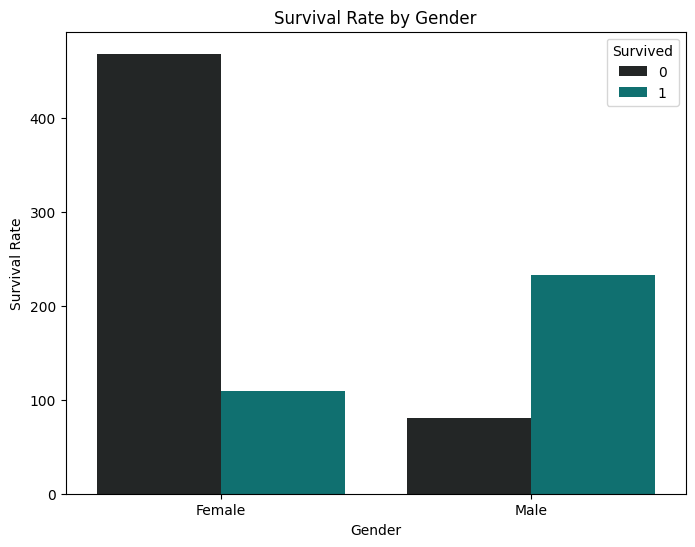

In [37]:
# Visualize survival by gender
plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='Survived', data=df, color="teal")  #hue adds a categorical dimension by coloring data points based on x variable

# adding labels and title
plt.xticks([0, 1], ['Female', 'Male'])                         #markers to denote a specific data points
plt.title('Survival Rate by Gender')
plt.ylabel('Survival Rate')
plt.xlabel('Gender')

plt.show()          # Show plot

In [38]:
# plot survived by fare(social class)

df.describe().T       # to get fare ranges using percentiles

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,891.0,29.361582,13.019697,0.42,22.0000,28.0000,35.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

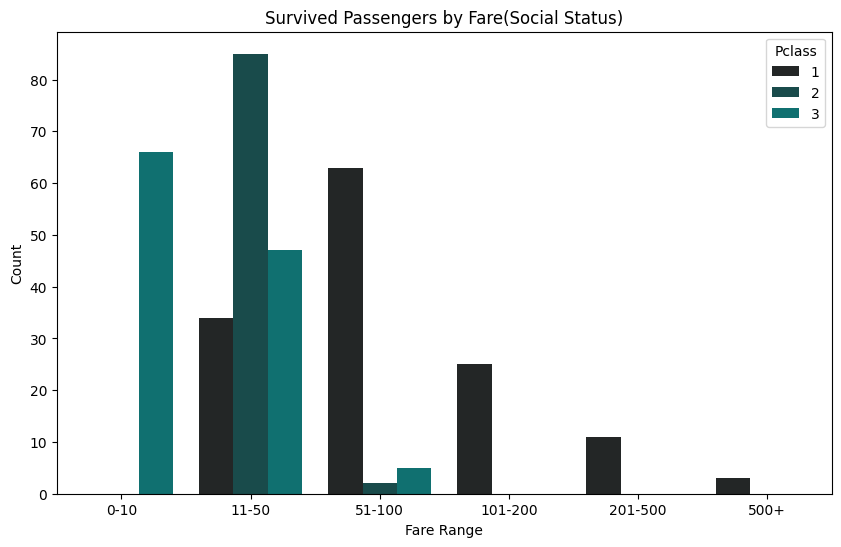

In [39]:
# Filter to get survived passengers only
survived_passengers = df[df['Survived'] == 1] 

# Define bins for different fare ranges
fare_bins = [0, 10, 50, 100, 200, 500, 1000]                                    # Numeric bin ranges for fare
fare_labels = ['0-10', '11-50', '51-100', '101-200', '201-500', '500+']         # Labels for fare bins

# Create a new column called fare_bin to categorize fare into bins
survived_passengers['Fare Bin'] = pd.cut(survived_passengers['Fare'], bins=fare_bins, labels=fare_labels)

# Plot a barplot of the survived passengers by fare bin and passenger class (pclass)
plt.figure(figsize=(10, 6))
sns.countplot(x='Fare Bin', hue='Pclass', data=survived_passengers, color="teal")

# Add labels and title
plt.title('Survived Passengers by Fare(Social Status)')
plt.xlabel('Fare Range')
plt.ylabel('Count')

plt.show()          # Show plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

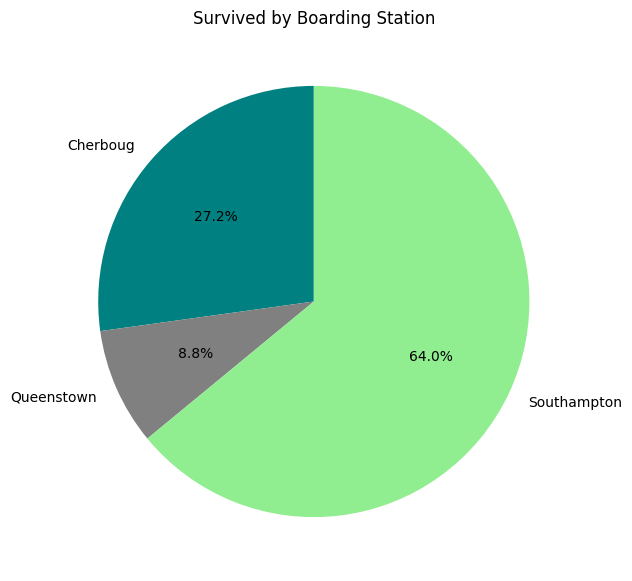

In [40]:
# Visualize survival by Boarding Station(Embarked column) 
survival_rate_by_embarked = survived_passengers.groupby('Embarked').size()   # group by survived passengers   

boarding_labels = ["Cherboug", "Queenstown", "Southampton"]

# Plot a pie chart
plt.figure(figsize=(7, 7))
survival_rate_by_embarked.plot(kind='pie', labels=boarding_labels, 
                               autopct='%1.1f%%', 
                               colors=['teal', 'grey', 'lightgreen'], startangle=90, legend=False)

# Add title
plt.title('Survived by Boarding Station')

plt.show()          # Show plot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

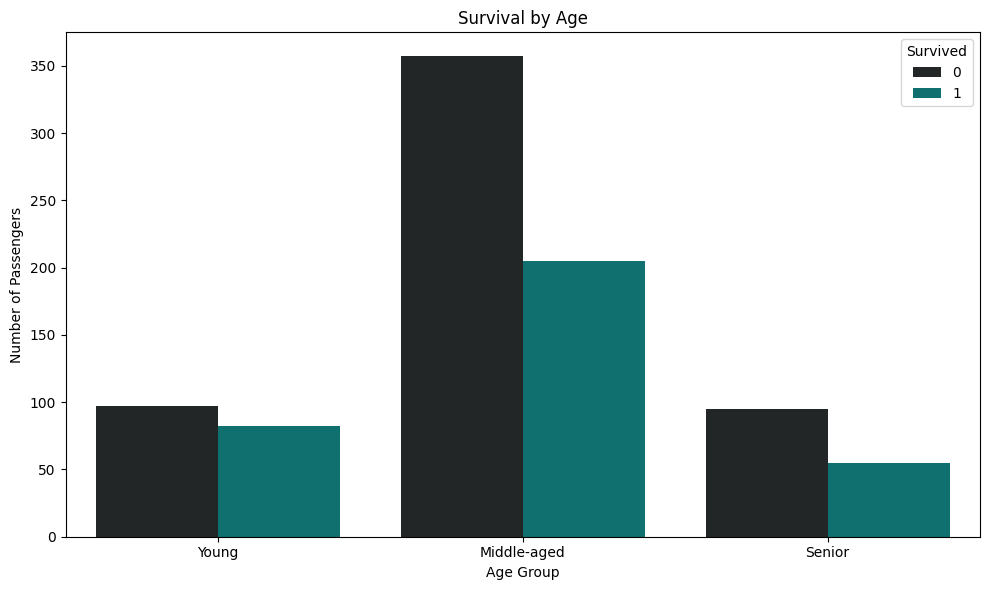

In [41]:
# Visualize survival by age group
# define bins and labels for different age ranges
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 20, 40, 80], labels=['Young', 'Middle-aged', 'Senior'])

# Plot a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_Group', hue='Survived', data=df, color="teal")

# Add title and labels
plt.title('Survival by Age')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')

plt.tight_layout()          # Show plot
plt.show()


#Encoding non numerical values

In [42]:
#label encoding for columns with 2 counts(survived)
le = LabelEncoder()

unique_counts = df.nunique()            #df.unique() count the number of unique counts in a df column

columns_to_encode = unique_counts[unique_counts<=2].index.to_list()

for col in columns_to_encode:
    df[col] = le.fit_transform(df[col])

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Group
0,0,3,1,22.0,1,0,7.2500,S,Middle-aged
1,1,1,0,38.0,1,0,71.2833,C,Middle-aged
2,1,3,0,26.0,0,0,7.9250,S,Middle-aged
3,1,1,0,35.0,1,0,53.1000,S,Middle-aged
4,0,3,1,35.0,0,0,8.0500,S,Middle-aged


In [43]:
#get.dummies() on columns with more than 2 unique counts
df =pd.get_dummies(df, drop_first=True, dtype=float)

df.head()

<IPython.core.display.Javascript object>

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Age_Group_Middle-aged,Age_Group_Senior
0,0,3,1,22.0,1,0,7.2500,0.0,1.0,1.0,0.0
1,1,1,0,38.0,1,0,71.2833,0.0,0.0,1.0,0.0
2,1,3,0,26.0,0,0,7.9250,0.0,1.0,1.0,0.0
3,1,1,0,35.0,1,0,53.1000,0.0,1.0,1.0,0.0
4,0,3,1,35.0,0,0,8.0500,0.0,1.0,1.0,0.0


4.Feature selection

A. Chi-Square Test with alpha = 0.05

H0: there is no significant relationship between the features (sex, passenger class, and embarked) and target (the survival rate)

In [44]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_Q', 'Embarked_S', 'Age_Group_Middle-aged',
       'Age_Group_Senior'],
      dtype='object')

In [45]:
df.shape

(891, 11)

In [46]:
from sklearn.feature_selection import chi2
x = df[["Sex", "Pclass",'Embarked_Q', 'Embarked_S']]
y = df["Survived"]

chi2_values, p_values = chi2(x, y)

print("Chi values:", chi2_values)
print("P_values:", p_values)

Chi values: [9.27024470e+01 3.08736994e+01 1.08467891e-02 5.48920482e+00]
P_values: [6.07783826e-22 2.75378563e-08 9.17051963e-01 1.91342437e-02]


From the chi square test:
The p-values< alpha for all the above features, so we reject the null hypothesis, and conclude there's a significant relationship between sex, passenger class, embarked and survival. 

We'll keep these features for the model.

B. Random Forest 

In [47]:
# define features and target variable
y = df["Survived"]
X = df.drop(columns=["Survived"], axis=1)

In [48]:
# Split the data into 2 sets. 80% for training and 20% for testing
#where X= features, y= target variable, and test_size= 0.2 means 20% is for testing, and 80% is for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier()                        # Train a Random Forest model
model.fit(X_train, y_train)                             # Fit the model to the training data

feature_importances = model.feature_importances_        # Get feature importance scores
features = X.columns                                    # Get feature names

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False) # Sort the DataFrame in descending order of importance
print(importance_df)



<IPython.core.display.Javascript object>

                 Feature  Importance
1                    Sex    0.272721
5                   Fare    0.264411
2                    Age    0.223881
0                 Pclass    0.090332
3                  SibSp    0.051575
4                  Parch    0.035876
7             Embarked_S    0.025249
8  Age_Group_Middle-aged    0.018722
6             Embarked_Q    0.009321
9       Age_Group_Senior    0.007911


From the Random Forest Classifier:
1. Sex, fare, age, passenger class, sibling-spouse parent child features have high  feature importance, so they have a significant relationship with the target variable. 
2. Ticket features don't have any significance in predicting the target variable.
3. Since sibling-spouse and parent-child features are correlated, let's feature engineer it into family size

Feature Engineering Sibling-Spouse(SibSp) and Parent-Child(ParCh) columns

In [49]:
# Create family size. Combine SibSp (siblings/spouses) and Parch (parents/children) features
df['Family Size'] = df['SibSp'] + df['Parch']

# Create bins for family size
family_size_bins = [0, 1, 3, 5, 10]                         # Define bin edges for family size
family_size_labels = ['Alone', 'Small', 'Medium', 'Large']  # Labels for each category

# Create a new column 'family group' using pd.cut to bin family sizes into categories
df['Family Group'] = pd.cut(df['Family Size'], bins=family_size_bins, labels=family_size_labels, right=False)

df.head()

<IPython.core.display.Javascript object>

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Age_Group_Middle-aged,Age_Group_Senior,Family Size,Family Group
0,0,3,1,22.0,1,0,7.2500,0.0,1.0,1.0,0.0,1,Small
1,1,1,0,38.0,1,0,71.2833,0.0,0.0,1.0,0.0,1,Small
2,1,3,0,26.0,0,0,7.9250,0.0,1.0,1.0,0.0,0,Alone
3,1,1,0,35.0,1,0,53.1000,0.0,1.0,1.0,0.0,1,Small
4,0,3,1,35.0,0,0,8.0500,0.0,1.0,1.0,0.0,0,Alone


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

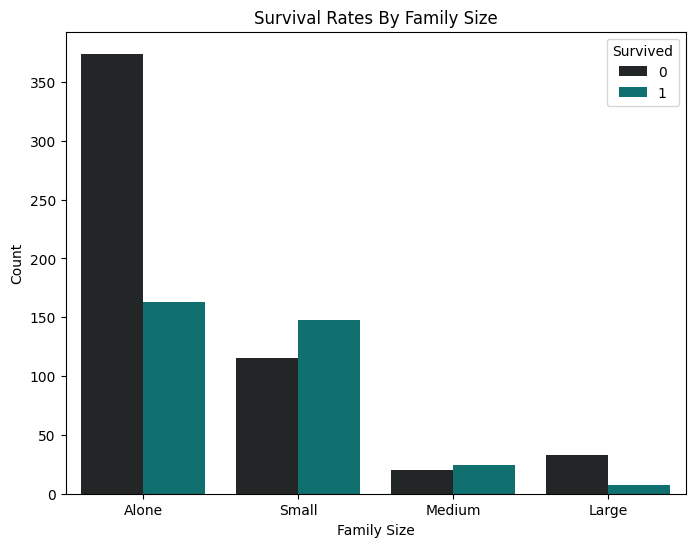

In [50]:
# Plot a barplot of survival by family groups
plt.figure(figsize=(8, 6))
sns.countplot(x='Family Group', hue= "Survived", data=df, color='teal')

# Add labels and title
plt.title('Survival Rates By Family Size')
plt.xlabel('Family Size')
plt.ylabel('Count')

plt.show()          # Show plot

5.Fit Model

In [51]:
# Split the data step. Splitting already done in the random forest feature selection
#  AKA the Holdout Method Cross Validation

In [52]:
# Standardize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<IPython.core.display.Javascript object>

In [53]:
# perform SMOTE(Synthetic Minority Over-Sampling Technique) on train data before fitting the model
# works by generating synthetic samples for the minority class to balance distribution to provide a more balanced set for better modelling

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Original data set:", y_train.shape[0])
print("Resampled data set:", y_resampled.shape[0])

Original data set: 712
Resampled data set: 888


In [54]:
#check if class balancing worked
y_resampled.value_counts()

Survived
0    444
1    444
Name: count, dtype: int64

A. Logistic Regression

In [55]:
# Initialize Logistic Regression model
logistic_model = LogisticRegression()

# train the model
logistic_model.fit(X_resampled, y_resampled)

LogisticRegression()

In [56]:
# 4. Make predictions
y_pred_logistic = logistic_model.predict(X_test)

In [57]:
#StratifiedFold Crossvalidation(CV)

# initialize stratifiedkfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# perform KFold CV
accuracies = []             # store accuracy scores for each fold
for train_index, test_index in skf.split(X, y):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]   # iloc indexes and slices numoy arrays for splitting based on indices returned by the SKF method
    y_train, y_test = y[train_index], y[test_index]

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Calculate accuracy for this fold
accuracy = accuracy_score(y_test, y_pred)
accuracies.append(accuracy)

# Print out accuracy scores for each fold
print(f"Accuracy scores for each fold: {accuracies}")

# Print the average accuracy across all folds
print(f"Average accuracy: {sum(accuracies)/len(accuracies)}")

Accuracy scores for each fold: [0.8089887640449438]
Average accuracy: 0.8089887640449438


In [58]:
# Perform cross-validation and get predictions
cross_val = cross_val_predict(logistic_model, X, y, cv=10)
# Evaluate the model
cross_accuracy = cross_val_score(logistic_model, X, y, cv=10, scoring='accuracy')
print("Accuracy: ", cross_accuracy)
print("Mean Accuracy: ", cross_accuracy.mean())


Accuracy:  [0.77777778 0.78651685 0.75280899 0.80898876 0.80898876 0.76404494
 0.78651685 0.7752809  0.80898876 0.84269663]
Mean Accuracy:  0.7912609238451935


In [59]:
#Hyparameter Tuning

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],        # Regularization strength
    'penalty': ['l1', 'l2'],                     # Regularization type (L1 or L2)
    'solver': ['liblinear', 'saga'],              # Solver types (liblinear for L1 and L2)
    'max_iter': [100, 200, 300]                   # Maximum number of iterations for convergence
}

grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")


Best parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.7868117797695262


In [60]:
#RandomizedSearchCV
param_dist = {  
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10)
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_dist, n_iter=100, cv=5)
random_search.fit(X_train, y_train)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Best parameters: {'max_depth': 24, 'min_samples_split': 6, 'n_estimators': 131}
Best cross-validation score: 0.8218950064020486


In [61]:
# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred_logistic)
# conf_matrix = confusion_matrix(y_test, y_pred_logistic)
# class_report = classification_report(y_test, y_pred_logistic)

# # Model Accuracy
# print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
# print("Confusion Matrix:")
# print(conf_matrix)
# print("Classification Report:")
# print(class_report)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

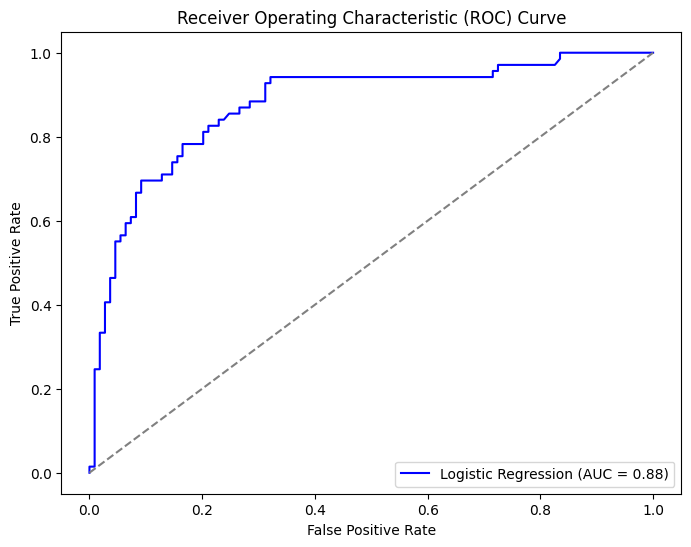

In [62]:
# ROC Curve for model 
y_prob_rf = logistic_model.predict_proba(X_test)[:, 1]          # Predict probabilities

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

#  Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

B. Decision Tree

In [63]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)

# Train Decision Tree Classifier
clf.fit(X_resampled, y_resampled)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [64]:
# make prediction
y_pred_dt = clf.predict(X_test)

In [65]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_dt)
conf_matrix = confusion_matrix(y_test, y_pred_dt)
class_report = classification_report(y_test, y_pred_dt)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.848314606741573
Confusion Matrix:
[[96 13]
 [14 55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       109
           1       0.81      0.80      0.80        69

    accuracy                           0.85       178
   macro avg       0.84      0.84      0.84       178
weighted avg       0.85      0.85      0.85       178



In [66]:
# # Perform cross-validation and get predictions
# cross_val = cross_val_predict(clf, X, y, cv=10)
# # Evaluate the model
# cross_accuracy = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
# print("Accuracy: ", cross_accuracy)
# print("Mean Accuracy: ", cross_accuracy.mean())
    

In [67]:
#KFold Crossvalidation(CV)

# initialize kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# perform KFold CV
accuracies = []             # store accuracy scores for each fold
for train_index, test_index in skf.split(X, y):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]   # iloc indexes and slices numoy arrays for splitting based on indices returned by the SKF method
    y_train, y_test = y[train_index], y[test_index]

# Train the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy for this fold
accuracy = accuracy_score(y_test, y_pred)
accuracies.append(accuracy)

# Print out accuracy scores for each fold
print(f"Accuracy scores for each fold: {accuracies}")

# Print the average accuracy across all folds
print(f"Average accuracy: {sum(accuracies)/len(accuracies)}")

Accuracy scores for each fold: [0.8146067415730337]
Average accuracy: 0.8146067415730337


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

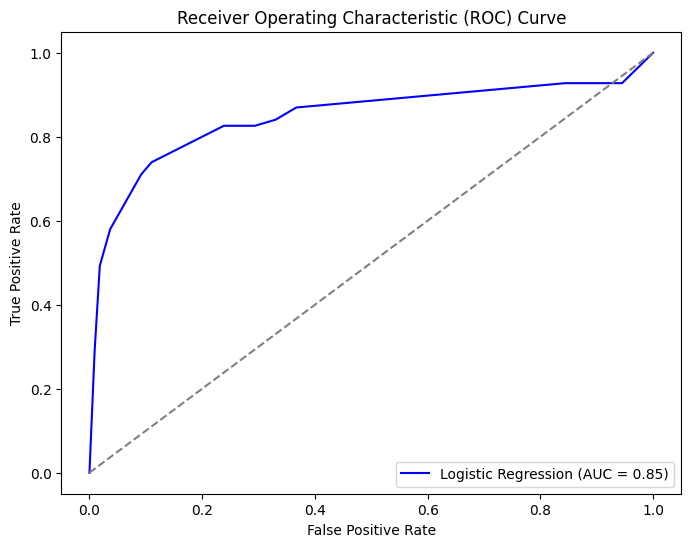

In [68]:
# ROC Curve for model 
y_prob_rf = clf.predict_proba(X_test)[:, 1]          # Predict probabilities

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

#  Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

C. Random Forest

In [69]:
# initialize Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# train model
rf.fit(X_resampled, y_resampled)

# make predictions
y_pred_rf = rf.predict(X_test)

In [70]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.8764044943820225
Confusion Matrix:
[[101   8]
 [ 14  55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       109
           1       0.87      0.80      0.83        69

    accuracy                           0.88       178
   macro avg       0.88      0.86      0.87       178
weighted avg       0.88      0.88      0.88       178



In [71]:
# Perform cross-validation and get predictions
cross_val = cross_val_predict(rf, X, y, cv=10)
# Evaluate the model
cross_accuracy = cross_val_score(rf, X, y, cv=10, scoring='accuracy')
print("Accuracy: ", cross_accuracy)
print("Mean Accuracy: ", cross_accuracy.mean())


Accuracy:  [0.78888889 0.83146067 0.74157303 0.88764045 0.8988764  0.80898876
 0.82022472 0.76404494 0.88764045 0.86516854]
Mean Accuracy:  0.829450686641698


In [72]:
#KFold Crossvalidation(CV)

# initialize kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# perform KFold CV
accuracies = []             # store accuracy scores for each fold
for train_index, test_index in skf.split(X, y):
    # Split data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]   # iloc indexes and slices numoy arrays for splitting based on indices returned by the SKF method
    y_train, y_test = y[train_index], y[test_index]

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Calculate accuracy for this fold
accuracy = accuracy_score(y_test, y_pred)
accuracies.append(accuracy)

# Print out accuracy scores for each fold
print(f"Accuracy scores for each fold: {accuracies}")

# Print the average accuracy across all folds
print(f"Average accuracy: {sum(accuracies)/len(accuracies)}")

Accuracy scores for each fold: [0.8314606741573034]
Average accuracy: 0.8314606741573034


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

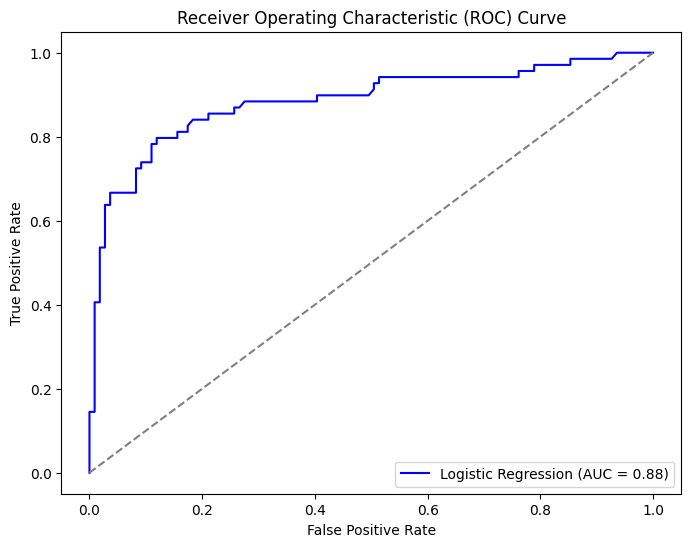

In [73]:
# ROC Curve for model 
y_prob_rf = rf.predict_proba(X_test)[:, 1]          # Predict probabilities

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

#  Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

D. Bagging Classifier

In [74]:
# initialize Bagging Classifier
bagging_clf = BaggingClassifier(n_estimators=20, random_state=42)

# train the model
bagging_clf.fit(X_resampled, y_resampled)

# make prediction
y_pred_bagging = bagging_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_bagging)
conf_matrix = confusion_matrix(y_test, y_pred_bagging)
class_report = classification_report(y_test, y_pred_bagging)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.848314606741573
Confusion Matrix:
[[103   6]
 [  3  66]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       109
           1       0.92      0.96      0.94        69

    accuracy                           0.95       178
   macro avg       0.94      0.95      0.95       178
weighted avg       0.95      0.95      0.95       178



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

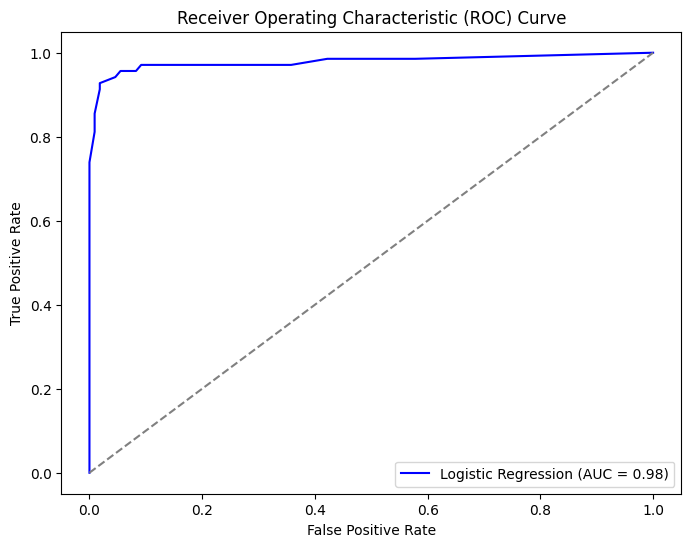

In [75]:
# ROC Curve for model 
y_prob_rf = bagging_clf.predict_proba(X_test)[:, 1]          # Predict probabilities

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

#  Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [76]:
y_true = y_test

# Define the function to calculate and return model metrics
def model_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }

# Initialize an empty list to store model results
results = []

# Example: After training each model, store results
# results.append(model_metrics(y_test, y_pred_logistic, "Logistic Regression"))
results.append(model_metrics(y_test, y_pred_dt, "Decision Tree"))
results.append(model_metrics(y_test, y_pred_rf, "Random Forest"))
results.append(model_metrics(y_test, y_pred_bagging, "Bagging Classifier"))

# Convert results list to a DataFrame
df = pd.DataFrame(results)

df.head() 

<IPython.core.display.Javascript object>

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.848315,0.808824,0.797101,0.802920
1,Random Forest,0.876404,0.873016,0.797101,0.833333
2,Bagging Classifier,0.949438,0.916667,0.956522,0.936170


From the above models, the Bagging Classifier is the best because it had the highest F-1 score

In [77]:
# # Plotting the confusion matrix using seaborn heatmap
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

Key Insights:

1. Sex was the most crucial determinant for survival. Rescuers prioritized female passengers
2. Social class (fare and passenger class) also heavily influenced survival because rescuers prioritized the elite and their cabins(first class) on the ship were closest to life boats.
3. Age influenced survival because rescue efforts prioritized younger passengers
4. Family ties influenced survival rates too since most survivors were related

Conclusion
1. Safety first, then design(the Titanic had less lifeboats to prioritize stunning ocean views for 1st class passengers)
2. Safety systems must be unbiased(prioritize the vulnerable, not social class)
3. Radar or obstacle detection technology can prevent such accidents (ice patrol)
4. Technology is only as good as its user(The Titanic crew ignored several iceberg warnings, and were unprepared for such disasters). Disaster preparedness training would go a long way

In [ ]:
#k-nearest neighbors model

k = 5  # Number of neighbors for KNN
knn = KNeighborsClassifier(n_neighbors=k)  # Initialize KNN model with 5 neighbors

# fit model
knn.fit(X_resampled, y_resampled)

# make predictions
knn_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, knn_pred)
conf_matrix = confusion_matrix(y_test, knn_pred)
class_report = classification_report(y_test, knn_pred)

# Model Accuracy
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.7921348314606742
Confusion Matrix:
[[87 22]
 [15 54]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       109
           1       0.71      0.78      0.74        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.78       178
weighted avg       0.80      0.79      0.79       178




Ensemble Methods

1. Adaboost Model

In [83]:
# import libraries
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


In [85]:
# basemodel for Adaboost classifier
base= DecisionTreeClassifier(max_depth=1) # Decision tree with max depth of 1

In [88]:
#Adaboost classifier

adaboost = AdaBoostClassifier(estimator=base, n_estimators=50, random_state=42) # 50 weak learners

In [ ]:
#  fit adaboost model
adaboost.fit(X_resampled, y_resampled)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [91]:
# make predictions with adaboost

y_pred_adaboost = adaboost.predict(X_test)

In [93]:
# evaluate model
accuracy = accuracy_score(y_test, y_pred_adaboost)
accuracy

0.8314606741573034

2. Stacking Classifier Model

In [94]:
# stacking classifiers

# import libraries
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [95]:
# create base estimators
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))
]

In [96]:
# initialize stacking classifier
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())


In [97]:
# fit stacking classifier
stacking.fit(X_resampled, y_resampled)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=5,
                                                       random_state=42)),
                               ('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=42)),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=LogisticRegression())

In [98]:
# make predictions
y_pred_stacking = stacking.predict(X_test)

In [99]:
# evaluate stacking model
accuracy = accuracy_score(y_test, y_pred_stacking)
print("Accuracy:", accuracy_score(y_test, y_pred_stacking))

Accuracy: 0.8932584269662921


Save models as pickle files to train unseen data

In [79]:
# Save the logistic regression model as a pickle file
with open("logistic regression.pkl", "wb") as file:
    pickle.dump(logistic_model, file)

In [80]:
# Save the decision tree model as a pickle file
with open("decision tree.pkl", "wb") as file:
    pickle.dump(clf, file)

In [81]:
# Save the random forest model as a pickle file
with open("random forest.pkl", "wb") as file:
    pickle.dump(rf, file)

In [82]:
# Save the bagging classifier as a pickle file
with open("bagging classifier.pkl", "wb") as file:
    pickle.dump(bagging_clf, file)